# 1 

# a). Problem Statment

> ### Task - The problem is mainly a BINARY IMAGE CLASSIFICATION PROBLEM. The Problem focuses on identifying the presence of metastases from a 96 * 96 digital histopathology images




# b). Analysis of the problem Statment

> ## What Exactly the problem statment conveys to us?
> ### 1. The problem deals with the Binary Classification of the Image that has a shape of 96px * 96px. It involves identifying metastases from the 96px * 96px digital  images.



### So, let's dive into the domain involving Data Collection:

- **The data provided for classification consists of histopathological images.** These are glass slide microscope images of lymph nodes.

- **Typically, nuclei are stained blue**, while the cytoplasm and extracellular parts appear in various shades of pink.

- **Lymph nodes are small glands** that filter the fluid in the lymphatic system, and they are often the first place breast cancer spreads to.

- **Histological assessment of lymph node metastases** is integral to determining the stage of breast cancer in the TNM classification, a globally recognized standard for classifying cancer spread.


# 2.  Data Understanding

* The dataset contains the histopathological Images, each image is 96px * 96px. 

* A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.






* ### **IS DATA RELEVANT TO THE PROBLEM ?**
> This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands).


# 3. Designing the Model  (Coding Part)

In [1]:
# Importing  Libraries
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

In [2]:
# Setting Some Pre-Requisites
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000         # We will be training 80,000 samples from each label

In [4]:
# So, what are the files which are available?

os.listdir('./histopathologic-cancer-detection')

['train_labels.csv', 'test', 'train', 'sample_submission.csv']

In [6]:
# So, how many images are there in each of the folder in the training dataset?

print(len(os.listdir('./histopathologic-cancer-detection/train')))
print(len(os.listdir('./histopathologic-cancer-detection/test')))

220025
57458


In [8]:
# Creating a dataframe of all the training images

df_data = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [9]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [10]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = df[col_name].unique()
    num_rows = len(categories)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 4 * num_rows))

    for i, category in enumerate(categories):
        sample_df = df[df[col_name] == category].sample(num_cols)
        
        for j, (_, sample_row) in enumerate(sample_df.iterrows()):
            image_file_path = f"{image_dir}{sample_row['id']}.tif"
            image = cv2.imread(image_file_path)
            
            axes[i, j].imshow(image, resample=True, cmap='gray')
            axes[i, j].set_title(category, fontsize=16)

    plt.tight_layout()
    plt.show()








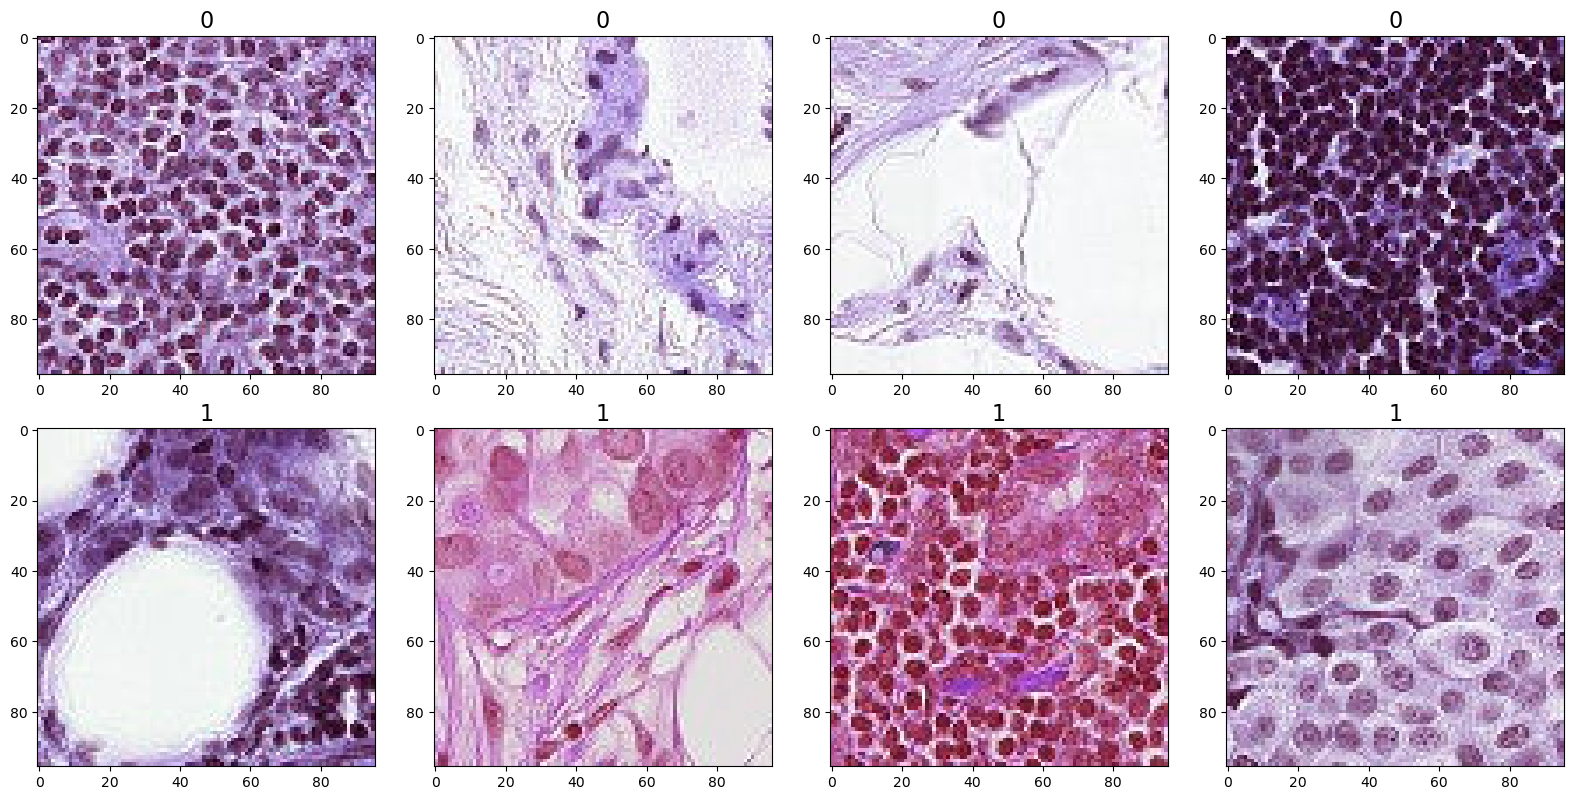

In [12]:
IMAGE_PATH = './histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [13]:
# Sample data based on label
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Combine and shuffle the sampled data
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True).sample(frac=1).reset_index(drop=True)

# Display label counts
df_data['label'].value_counts()

0    80000
1    80000
Name: label, dtype: int64

In [14]:
# Now, for the train-test split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [15]:
# Create a new directory so that we will be using the ImageDataGenerator
base_dir = 'base_dir'
os.makedirs(base_dir)

sub_dirs = ['train_dir', 'val_dir']
classes = ['a_no_tumor_tissue', 'b_has_tumor_tissue']

# Create train and validation directories with class sub-directories
for sub_dir in sub_dirs:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, sub_dir, class_name))
# check that the folders have been created
os.listdir('base_dir/train_dir')

In [16]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [17]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [20]:
import os
import shutil

def transfer_images(image_list, destination_dir, df):
    for image in image_list:
        fname = f"{image}.tif"
        target = df.loc[image, 'label']
        
        label = 'a_no_tumor_tissue' if target == 0 else 'b_has_tumor_tissue'

        src = os.path.join('./histopathologic-cancer-detection/train', fname)
        dst = os.path.join(destination_dir, label, fname)
        
        shutil.copyfile(src, dst)

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Transfer the train and val images
transfer_images(train_list, train_dir, df_data)
transfer_images(val_list, val_dir, df_data)

In [21]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

72000
72000


In [22]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

8000
8000


In [23]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = './histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [24]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### The model that I have choosen for this problem has been taken from <a href = 'https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb'>Baseline Keras CNN</a>

In [25]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [26]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [27]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [29]:
train_steps = 500

In [30]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20


/var/folders/3k/vhmk7kx14ybb600l38fbqg780000gn/T/ipykernel_68365/4098454996.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


500/500 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 95s 189ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5030WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 91s 181ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 83s 167ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 81s 163ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 82s 164ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5040WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 83s 166ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5096WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 82s 165ms/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5032WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 81s 162ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5006WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 81s 161ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5150WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 81s 163ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5024WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 84s 168ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5018WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 88s 176ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5094WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 88s 176ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 14/20
500/500 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4952WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 87s 173ms/step - loss: 0.6933 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5010WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 84s 167ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 84s 167ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5046WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 82s 164ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5070WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 81s 162ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5106WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 81s 162ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 20/20
500/500 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5126WARNING:tensorflow:Can save best model only with val_acc available, skipping.


500/500 [==============================] - 82s 165ms/step - loss: 0.6929 - accuracy: 0.5126 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 0.0010


In [31]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [32]:
# Here the best epoch will be used.



val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

/var/folders/3k/vhmk7kx14ybb600l38fbqg780000gn/T/ipykernel_68365/2341706544.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen,


val_loss: 0.6933144330978394
val_acc: 0.5


<Figure size 640x480 with 0 Axes>

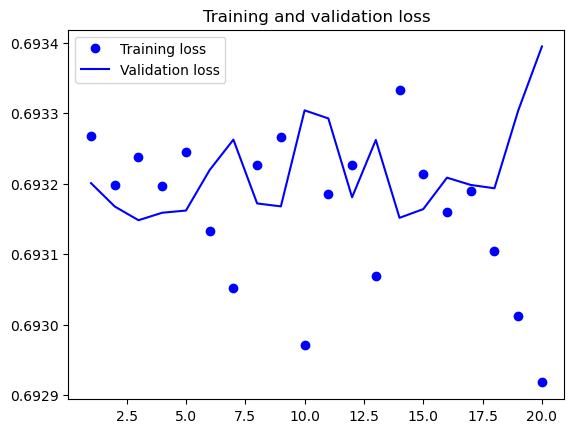

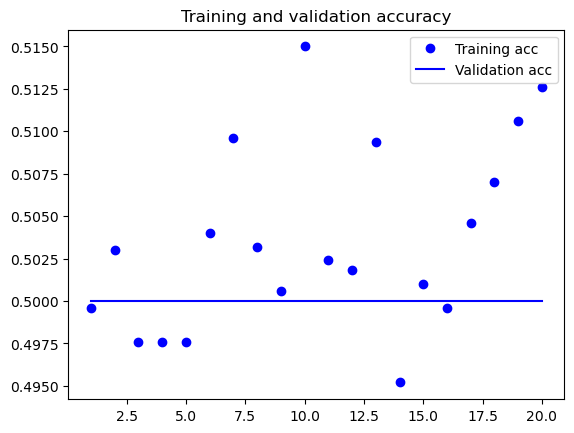

<Figure size 640x480 with 0 Axes>

In [33]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# 4. Validation and Analysis 

* ### Metrics
* ### Prediction and Activation Visualizations
* ### ROC and AUC

In [34]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

/var/folders/3k/vhmk7kx14ybb600l38fbqg780000gn/T/ipykernel_68365/2435426349.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


16000/16000 [==============================] - 73s 5ms/step


In [35]:
predictions.shape

(16000, 2)

In [36]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [37]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()


,no_tumor_tissue,has_tumor_tissue
0,0.477844,0.522156
1,0.477844,0.522156
2,0.477844,0.522156
3,0.477844,0.522156
4,0.477844,0.522156


In [38]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.5

In [40]:
# Get the labels of the test images.

test_labels = test_gen.classes
test_labels.shape

(16000,)

In [41]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [43]:
!pip install sklearn


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [45]:
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [46]:
# Delete base_dir and it's sub folders to free up disk space.

shutil.rmtree('base_dir')
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [49]:
# Transfer the test images into image_dir

test_list = os.listdir('./histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('./histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

In [50]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [51]:
num_test_images = 57458



predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

   23/57458 [..............................] - ETA: 4:34

/var/folders/3k/vhmk7kx14ybb600l38fbqg780000gn/T/ipykernel_68365/3697970497.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)


57458/57458 [==============================] - 244s 4ms/step


In [52]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

57458

In [53]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.477844,0.522156
1,0.477844,0.522156
2,0.477844,0.522156
3,0.477844,0.522156
4,0.477844,0.522156


In [54]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.477844,0.522156,test_images/00006537328c33e284c973d7b39d340809...
1,0.477844,0.522156,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.477844,0.522156,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.477844,0.522156,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.477844,0.522156,test_images/000270442cc15af719583a8172c87cd2bd...


In [55]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.477844,0.522156,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.477844,0.522156,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.477844,0.522156,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.477844,0.522156,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.477844,0.522156,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [56]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

### Confusion Matrix

# 5. Submission

In [57]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.522156
0000ec92553fda4ce39889f9226ace43cae3364e,0.522156
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.522156
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.522156
000270442cc15af719583a8172c87cd2bd9c7746,0.522156


In [58]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('test_dir')

# Confusion Matrix

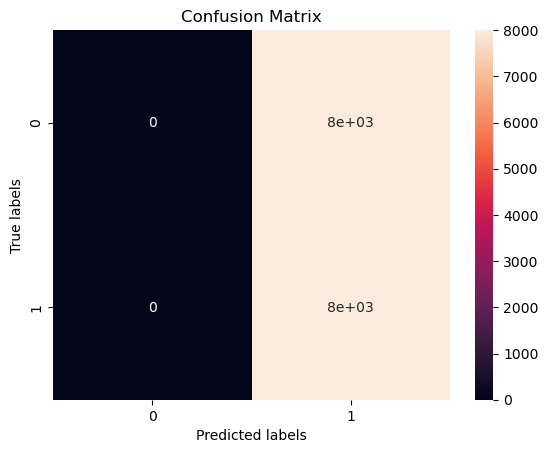

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 